![MLA Logo](https://drive.corp.amazon.com/view/mrruckma@/MLA_headerv2.png?download=true)

In [ ]:
!pip install --upgrade pip
!pip install -U scikit-image

### 1. Download the Dataset

Our labels correspondend to the following:

    Class 0: Inconclusive
    Class 1: Two wheels
    Class 2: Four wheels
    Class 3: Not luggage
    Class 4: Zero wheels



We are reading it into a Data Frame. 

In [104]:
#Let's read in our training data. ASINs correspond to those in Leaderboard's ID.
import pandas as pd

df = pd.read_pickle("/tmp/training_data.pkl")

df.head()

,ID,data,label
0,1588,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",4
1,2011,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",1
2,1321,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",4
3,669,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",3
4,1674,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",1


Let's plot some images below.

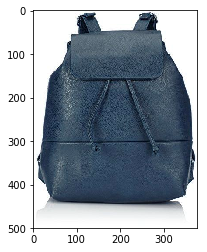

In [105]:
#Let's see what kind of data we're working with
import matplotlib.pyplot as plt

plt.imshow(df['data'][91])

In [106]:
# Let's take a look at this data in more detail and then start working. Remember 'label' is our target variable/column
df.loc[91].label


4

### 2. Split the dataset and Process Images
#### * We split the original dataset into Training (80%), Validation (10%) and Test (10%) subsets. 
#### * We will process images by resizing to 224x224 and converting (row, column, channel) to (channel, row, column)

In [107]:
import numpy as np
from skimage.transform import resize
from skimage.transform import rotate
from mxnet import gluon

# Let's split to data into training (90%), validation (10%) subsets (test is seperate file).
train_indices = np.arange(0, int(0.9*len(df)))
val_indices = np.arange(int(0.9*len(df)), len(df))

# balance test data a little
bal_indices = []
for i in range(train_indices.size):
    if df.loc[train_indices[i]].label == 3 :
        bal_indices = np.append(bal_indices, np.full(1, train_indices[i]))

train_df = df.iloc[train_indices]
val_df = df.iloc[val_indices]
bal_df = df.iloc[bal_indices]

del df

def getImages(images):
    # Create the image holder array
    image_arr = np.zeros((images.shape[0], 3, 224, 224), dtype="float32")
    
    # Iterate through the image data
    for i, im in enumerate(images):
        # Get image from the data column of the current row
        
        # We need a fixed size input, our images have different sizes, let's pick 224x224.
        # Resize image below
        im = resize(im, output_shape=(224, 224))
        
        # Gluon/mxnet expects images in this format (channel, row, column)
        # This is the opposite of (row, column, channel), let's fix it
        im = np.moveaxis(im, -1, 0)
        
        # Assign the value in the image array
        image_arr[i] = im

    return image_arr

def getModImages(images):
    # Create the image holder array
    image_arr = np.zeros((images.shape[0], 3, 224, 224), dtype="float32")
    
    # Iterate through the image data
    for i, im in enumerate(images):
        # Get image from the data column of the current row and rotate it 90deg
        im = rotate(im, 90)
        
        # We need a fixed size input, our images have different sizes, let's pick 224x224.
        # Resize image below
        im = resize(im, output_shape=(224, 224))
        
        # Gluon/mxnet expects images in this format (channel, row, column)
        # This is the opposite of (row, column, channel), let's fix it
        im = np.moveaxis(im, -1, 0)
        
        # Assign the value in the image array
        image_arr[i] = im

    return image_arr

train_images, train_labels = getImages(train_df["data"].values), train_df["label"].values
validation_images, validation_labels = getImages(val_df["data"].values), val_df["label"].values

# pad images
pad_images, pad_labels = np.append(train_images, getModImages(bal_df["data"])),np.append(train_labels, bal_df["label"])

# Using Gluon Data loaders to load the data in batches
train_dataset = gluon.data.ArrayDataset(pad_images, pad_labels)
validation_dataset = gluon.data.ArrayDataset(validation_images, validation_labels)

AssertionError: All arrays must have the same length; array[0] has length 248672256 while array[2] has 1652.

In [ ]:

#bal_df.size
#train_images.size
#train_labels.size
pad_images.size
pad_labels.size


### 3. Plot the training class distribution

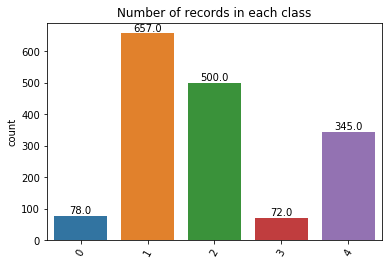

In [79]:
import matplotlib.pyplot as plt
import seaborn as sb

plt.figure()
ax = sb.countplot(x=train_labels, y = None)
for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate(y, (x.mean(), y), ha='center', va='bottom') 
plt.xticks(rotation=60)
plt.title('Number of records in each class')
plt.show()

### 3. Plot the test class distribution

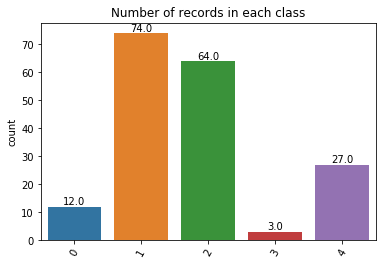

In [80]:
import matplotlib.pyplot as plt
import seaborn as sb

plt.figure()
ax = sb.countplot(x=test_labels, y = None)
for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate(y, (x.mean(), y), ha='center', va='bottom') 
plt.xticks(rotation=60)
plt.title('Number of records in each class')
plt.show()

### 4. Confusion Matrix 
#### We have the following function to plot confusion matrix. We will call this function to plot confusion matrix for our validation data after each epoch (one full pass through the training dataset)


In [81]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cm, index = [i for i in ['0', '1', '2', '3', '3']], columns = [i for i in ['0', '1', '2', '3', '4']])
    plt.figure(figsize = (5, 5))
    plt.title('Validation Confusion Matrix')
    sn.heatmap(df_cm, annot=True)
    plt.show()

### 3. Build the Convolutional Neural Network
* We will use two Convolution-Pooling pairs
* Flatten after them
* A fully connected layer
* Dense output layer

In [82]:
from mxnet.gluon.model_zoo import vision
import mxnet as mx

def build_network(num_outputs):
    # Set this to GPU or CPU
    ctx = mx.gpu()
    #ctx = mx.cpu()

    # Get the pre-trained network
    pre_trained_net = vision.alexnet(pretrained=True, ctx=ctx)

    # Get the non-trained network
    net = vision.alexnet(classes=num_outputs, ctx=ctx)
    
    # Initialize weights
    net.collect_params().initialize(mx.init.Xavier(magnitude=2.24), ctx=ctx)
    
    # Copy weights from the trained network
    net.features = pre_trained_net.features

    return net

### 5. Training the network
#### Let's put the training data in the MXnet format and start training. Summarizing our steps:
#### * Select the correct compute type cpu or gpu
#### * Split the dataset into training, validation and test splits
#### * Create Gluon-specific data loaders
#### * Create the network and training algorithm
#### * Loop through dataset. We have only 5 epochs thaks to pre-trained network. We will train with training dataset and validate with the validation dataset.

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/pandas/plotting/_core.py:1001: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(left, right)
/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/pandas/plotting/_core.py:1001: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(left, right)


ValueError: Found input variables with inconsistent numbers of samples: [1652, 1616]

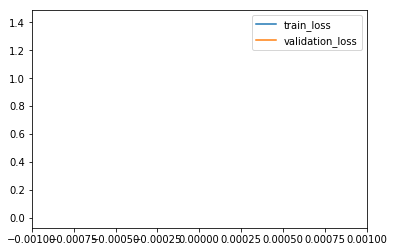

In [83]:
import numpy as np
from mxnet import gluon, autograd, ndarray
import mxnet as mx
import mxnet.ndarray as nd
from mxnet.gluon.loss import SoftmaxCrossEntropyLoss
from sklearn.metrics import accuracy_score

# Set this to GPU or CPU 
ctx = mx.gpu()
#ctx = mx.cpu()

# Set the batch size and initial learning rate
batch_size = 100
epochs = 10
learning_rate = 0.02
momentum = 0.2

# ------ Create Network and Training Logic -------- #

# Create the network. We have 5 classes
num_outputs = 5

net = build_network(num_outputs)

# Define loss and trainer.
softmax_cross_etropy_loss = gluon.loss.SoftmaxCrossEntropyLoss()
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': learning_rate})
#trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': learning_rate, 'momentum': momentum})
# ------------------------------------------------- #

train_loader = gluon.data.DataLoader(train_dataset, batch_size=batch_size)
validation_loader = gluon.data.DataLoader(validation_dataset, batch_size=batch_size)

train_losses = []
valid_losses = []

for epoch in range(epochs):

    # decay learning rate after epoc 3
    if epoch > 3:
            trainer.set_learning_rate(trainer.learning_rate * 0.6)
            
    # training loop (with autograd and trainer steps, etc.)
    cumulative_train_loss = 0
    train_predictions = []
    for i, (data, label) in enumerate(train_loader):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        with autograd.record():
            output = net(data)
            train_predictions = train_predictions + np.argmax(output.asnumpy(), axis=1).tolist()
            loss = softmax_cross_etropy_loss(output, label)
            cumulative_train_loss = cumulative_train_loss + nd.sum(loss)
        loss.backward()
        trainer.step(data.shape[0])
        
    train_loss = cumulative_train_loss/len(train_images)

    # validation loop
    cumulative_valid_loss = 0
    val_predictions = []
    for i, (data, label) in enumerate(validation_loader):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        output = net(data)
        val_predictions = val_predictions + np.argmax(output.asnumpy(), axis=1).tolist()
        val_loss = softmax_cross_etropy_loss(output, label)
        cumulative_valid_loss = cumulative_valid_loss + nd.sum(val_loss)
        
    valid_loss = cumulative_valid_loss/len(validation_images)

    # graph training loss
    train_losses.append(train_loss.asnumpy()[0])
    valid_losses.append(valid_loss.asnumpy()[0])
    pd.DataFrame({'train_loss':train_losses, 'validation_loss': valid_losses}).plot()

    # Calculate training and validation accuracies
    train_accuracy = accuracy_score(train_labels, train_predictions)
    validation_accuracy = accuracy_score(validation_labels, val_predictions)
    
    # Print the summary and plot the confusion matrix after each epoch
    print("Epoch {}, training loss: {:.2f}, validation loss: {:.2f}, training accuracy: {:.2f}, validation accuracy: {:.2f}".format(epoch, train_loss.asnumpy()[0], valid_loss.asnumpy()[0], train_accuracy, validation_accuracy))
    plot_confusion_matrix(validation_labels, val_predictions)

# 6. Test on test dataset
#### We are done with the training and validation. Let's get the test predictions below. 

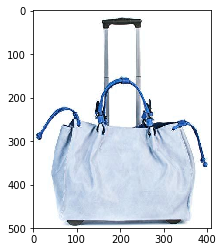

In [39]:
# If you're unsure of how to submit to Leaderboard, no problemo.You'll use the training file loaded above to make your ML model and then predict on the files below:

test_df = pd.read_pickle("/tmp/test_data.pkl")
plt.imshow(test_df['data'][101])

In [36]:
test_images = getImages(test_df["data"].values)
test_loader = gluon.data.DataLoader(test_images, batch_size=batch_size)

test_predictions = []
for i, data in enumerate(test_loader):
    data = data.as_in_context(ctx)
    output = net(data)
    test_predictions = test_predictions + np.argmax(output.asnumpy(), axis=1).tolist()
print(test_predictions)

[1, 1, 4, 4, 2, 4, 2, 1, 4, 1, 2, 4, 2, 1, 1, 1, 4, 1, 1, 1, 1, 4, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 4, 2, 1, 0, 2, 1, 1, 2, 1, 4, 2, 4, 1, 1, 2, 1, 2, 4, 1, 4, 1, 2, 1, 1, 4, 2, 2, 1, 1, 4, 1, 1, 2, 2, 1, 1, 1, 2, 4, 1, 4, 1, 4, 4, 4, 1, 1, 2, 4, 2, 1, 4, 4, 4, 1, 4, 2, 4, 1, 1, 1, 2, 2, 2, 1, 1, 1, 4, 1, 1, 4, 1, 1, 2, 2, 4, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 1, 1, 4, 1, 4, 1, 2, 4, 2, 1, 1, 1, 2, 4, 2, 1, 4, 2, 2, 1, 4, 2, 2, 2, 1, 1, 4, 2, 4, 4, 1, 4, 1, 4, 4, 1, 1, 2, 2, 1, 4, 1, 4, 2, 2, 2, 2, 2, 4, 4, 1, 2, 2, 1, 1, 4, 2, 2, 1, 2, 4, 1, 2, 4, 4, 2, 1, 1, 4, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 1, 2, 4, 4, 2, 2, 1, 2, 2, 0, 2, 2, 4, 4, 1, 2, 2, 2, 4, 4, 2, 4, 1, 1, 2, 2, 1, 2, 1, 2, 1, 4, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 4, 2, 2, 1, 4, 2, 1, 1, 1, 4, 1, 2, 4, 2, 1, 1, 1, 2, 4, 2, 2, 1, 1, 4, 2, 2, 1, 1, 1, 1, 4, 4, 1, 2, 2, 1, 4, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 2, 2, 4, 4, 1, 1, 1, 4, 0, 4, 4, 2, 1, 2, 2, 1, 1, 1, 1, 4, 1, 2, 1, 1, 1, 2, 2, 2, 2, 2, 4, 1, 

In [37]:
import pandas as pd

result_df = pd.DataFrame(columns=['ID', 'label'])
result_df["ID"] = test_df["ID"]
result_df["label"] = test_predictions

result_df.to_csv("results_cv_example_v2.csv", index=False)

If you navigate to the day1/results folder in the Jupyter file browser, you can select the results_cv_project.csv and dowload it locally. Or just click this [link...](./results_cv_project.csv)

## Getting our model output into Leaderboard

We now have our model's output .csv and are ready to upload to Leaderboard
1. Go to your class [Leaderboard instance](https://leaderboard.corp.amazon.com/tasks/312) and go to the 'Make a Submission' section
2. Upload your local file and include your notebook version URL for tracking
3. Your score on the public leaderboard should now appear. Marvel on how much room for improvement there is